In [2]:
import pyvisa
import numpy as np
import time
import pandas as pd
import os
import sys
import CVCommands
import JVfunctions
from os import path
from simple_pid import PID
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from pyvisa import ResourceManager, constants
from usb.core import find as finddev
from IPython.display import clear_output

In [7]:
sampName = 'CS610B-3'
cellNum = '003'
A = 0.17 #For JV scan

fastScan = True #Uses a voltage fit to speed up scan time, if fit is not available one will be made

V_fitmax = 15 #Maximum Vsmu output
V_fitmin = -1 #Minimum Vsmu output
fitby = 'SMU' #'SMU' or 'CONTROL', fit by setting the value of the [SMU] or by [CONTROL]ling to setpoint value
                #fitting by SMU is much faster

#Values for CIGS fine scan
V_i = 1.4 #Initial bias V (V)
V_f = -1 #Final bias V (V)
V_step = 100 #Number of steps

Freq_i=2
Freq_f=6
Freq_step=100

amp=0.05

num_avg = 5 #Number of measurements to average

delay = .1 #Delay between changing to new value

holdbias = True #Toggle to hold device at bias before measurement
hold_val = V_i #Voltage to hold at in V
hold_time = 30 #Time to hold voltage in s

pulseScan = False #Measurement V pulse on or off
pulse_time = 10 #Pulse time in s
#Soak at voltage before taking measurement
soak = False #Soak on/off
soak_time=1 #Soak time in s

takeJV = False
V_jvi = 0
V_jvf = 1
jv_avg = 5
jv_pts = 5
plc = .01
bufdelay = .01
prebias = False
biasV = 0
biastime = 0
pulse = False
pulsedelay = 0

####################################################

#PID tuning parameters for V setpoint
Ku = 1.3
Tu = 1
CVCommands.P = 0.45*Ku    #3.06
CVCommands.I = 0.54*Ku/Tu    #2.8
CVCommands.D = 0.0

CVCommands.offset = 0.1 #Acceptable tolerance for voltage setpoint in V

CVCommands.reset_i = 0 #Subtract this value from voltage setpoint to improve PID speed
CVCommands.reset = 5 #Subtract value from setpoint after reset trigger

CVCommands.reset_val = 1000 #Trigger voltage setpoint reset after iterations
CVCommands.shutoff_val = 1000 #Max iterations before shutdown
CVCommands.num_avg = num_avg
CVCommands.mvavg_num = 20 #Number of points to calculate voltage setpoint moving average

CVCommands.v_ceiling = 35 #Max allowable voltage sent to SMU, maximum value 35

CVCommands.trig_delay = 1
CVCommands.meas_speed = 'SLOW2' #FAST, MED, SLOW, SLOW2
CVCommands.lowz = 'ON'

CVCommands.LCR_timeout = 60*1000



Creating voltage fit for: CS610B-3...


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting complete
Fit from Vmin = -0.99898784 to Vmax = 1.31092008
Saved as Vfitdata_CS610B-3


Frequency sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221052_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221104_0kHz                              
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221115_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221125_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221132_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221139_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221145_0kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221151_0kHz                              
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221157_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221202_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221208_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221213_0kHz                              
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221218_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221228_0kHz                             
Measurement complete
Data saved
Waiting                                                     


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221238_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221247_0kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221255_0kHz                             
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221303_0kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221311_1kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221320_1kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221328_1kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221337_1kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221344_1kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221351_1kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221358_1kHz                             
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221404_1kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221418_1kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221431_1kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221442_1kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221452_1kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221500_2kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221508_2kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221514_2kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221520_2kHz                             
Measurement complete
Data saved
Waiting                                                    


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221529_2kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221538_3kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221546_3kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221553_3kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221604_3kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221613_4kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221622_4kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221630_5kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221638_5kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221645_5kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221654_6kHz                             
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221703_7kHz                             
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221711_7kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221718_8kHz                             
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221725_9kHz                             
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221732_10kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221738_10kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221751_11kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221804_13kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221815_14kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221824_15kHz                              
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221833_17kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221839_18kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221846_20kHz                            
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221856_22kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221905_24kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221913_27kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221921_29kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221929_32kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221939_35kHz                            
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221949_39kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217221957_42kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222006_46kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222014_51kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222023_56kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222033_61kHz                            
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222041_67kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222049_74kHz                            
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222057_81kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222104_89kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222111_98kHz                            
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222117_107kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222127_118kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222136_129kHz                           
Measurement complete
Data saved
Waiting                                                            


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222145_142kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222153_156kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222200_171kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222207_187kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222214_206kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222224_226kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222234_248kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222243_272kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222250_298kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222256_327kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222304_359kHz                          
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222312_394kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222319_433kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222326_475kHz                           
Measurement complete
Data saved
Waiting                                                        


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222332_521kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222340_572kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222347_628kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0217222354_689kHz                           
Measurement complete
Data saved
Waiting                                                         


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0218220001_756kHz                           
Measurement complete
Data saved
Waiting                                                      


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0218220007_830kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0218220012_911kHz                           
Measurement complete
Data saved
Waiting                                                       


Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS610B-3_CV_0218220018_1000kHz                          
Measurement complete
Data saved


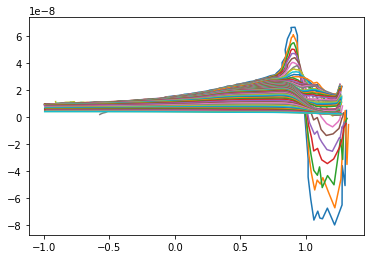

In [8]:
os.chdir('/home/pi/Desktop/CV')
foldname = datetime.today().strftime('%m-%d-%Y')
now = datetime.now()
currtime = now.strftime("%m%d%y%H%M")
month_format=datetime.today().strftime('%m-%Y')
currtime_format = now.strftime("%m/%d/%y %H:%M")

if os.path.isdir(month_format) is False:
    os.mkdir(month_format)
    os.chdir(month_format)
else:
    os.chdir(month_format)   

if os.path.isdir(foldname) is False:
    os.mkdir(foldname)

os.chdir(foldname)

CVFfoldname = ''.join(['CVF_',currtime])
if os.path.isdir(CVFfoldname) is False:
    os.mkdir(CVFfoldname)
os.chdir(CVFfoldname)

try:
    DMM.query('*IDN?')
except:
    rm = pyvisa.ResourceManager()
    DMMdev = finddev(idVendor=0x05e6, idProduct=0x2100) #Device ID for DMM
    DMMdev.reset() 
    DMM = rm.open_resource('USB0::1510::8448::1182494::0::INSTR')
    LCR = rm.open_resource('GPIB0::17::INSTR')
    SMU = rm.open_resource('GPIB0::24::INSTR')
  
    CVCommands.LCR = LCR
    CVCommands.SMU = SMU
    CVCommands.DMM = DMM
    CVCommands.SMU_configure()
    CVCommands.playstair()
    CVCommands.playon()

CVCommands.fastScan = fastScan
CVCommands.sampName = sampName
CVCommands.LCR_configure()
CVCommands.LCR_CGD()

error = False

time.sleep(1)
################################################

if fastScan == True:
    if path.exists(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName])):
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t')
    else:
        CVCommands.voltFit(V_fitmin,V_fitmax,fitby)
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t') 


#Sets LCR oscilation voltage
CVCommands.set_oscVolt(amp)

try:
    start_time = time.time()
    for k in tqdm(np.logspace(Freq_i,Freq_f,Freq_step),desc='Frequency sweep'):
        freq = k

        CVCommands.setFreq(freq)

        now = datetime.now()
        currtime = now.strftime("%m%d%y%H%M")

        V_arr = []
        c_arr = []
        f_arr = []
        g_arr = []
        d_arr = []
        time_arr = []
        if holdbias is True:

            CVCommands.setBias(hold_val,True,fastScan)

            print('Prebiasing device for '+str(holdval)+' seconds')
            time.sleep(hold_time)        
        
        if takeJV == True:
            JVfunctions.JVscan(sampName, A, V_jvi, V_jvf, jv_avg, jv_pts, plc, bufdelay, prebias, biasV, biastime, pulse, pulsedelay)
            CVCommands.SMU_configure()
            
        for i in tqdm(np.linspace(V_i,V_f,V_step),desc=''.join(['Voltage sweep'])):

            CVCommands.setBias(i,True,fastScan)
            if soak == True:
                time.sleep(soak_time)
            c, g, d = CVCommands.getData()

            V_arr.append(float(DMM.query(':READ?')))
            f_arr.append(freq)
            c_arr.append(c)
            g_arr.append(g)
            d_arr.append(d)
            
            end_time = time.time()
            time_tot = end_time-start_time
            time_arr.append(time_tot)
            if pulseScan == True:
                CVCommands.setBias(0,True,fastScan)
                DMM.query(':READ?')
                time.sleep(pulse_time)

        
        tempdict = {
            'DC Bias (V)' : V_arr,
            'Capacitance (F)' : c_arr,
            'Conductance (S)' : g_arr,
            'Dissipation (D)' : d_arr,
            'Frequency (Hz)' : f_arr,
            'Scan time (s)' : time_arr

        }



        info_labels = ['Sample Name: ','Cell Number: ','V start: ','V final: ','V steps: ','Freq start: ','Freq final: ','Freq steps: ','AC amp: ','Start time: ']
        info_data = [sampName,cellNum,V_i,V_f,V_step,10**Freq_i,10**Freq_f,Freq_step,amp,currtime_format]

        dictlen = len(tempdict[list(tempdict.keys())[0]])
        infolen = len(info_data)

        if dictlen >= infolen:
            info_labels = info_labels+[np.nan]*(dictlen-infolen)
            info_data = info_data+[np.nan]*(dictlen-infolen)
        else:
            for i in tempdict:
                tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

        tempdict['Info1'] = info_labels
        tempdict['Info2'] = info_data
        
        print('Saving as: '+''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']))
        globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])] = pd.DataFrame(tempdict)
        globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])].to_csv(''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']),sep='\t')

        CVCommands.offBias()


        print('Measurement complete')
        print('Data saved')

        plt.plot(globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['DC Bias (V)']
                 ,globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['Capacitance (F)'])
        #clear_output(wait=True)
except KeyboardInterrupt as e:
    CVCommands.offBias()
    error = True
    print(e)
    print('Interrupt')
LCR.write(':TRIG INT')  
if error == False:
    time.sleep(0.5)
    CVCommands.playchest()
else:
    CVCommands.playrand(10,0.05)